In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [3]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 9), (3888, 7))

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_train[['Hour','DHI','DNI','WS','RH','T']] = scaler.fit_transform(df_train[['Hour','DHI','DNI','WS','RH','T']])
df_test[['Hour','DHI','DNI','WS','RH','T']] = scaler.fit_transform(df_test[['Hour','DHI','DNI','WS','RH','T']])

In [6]:
Day  = df_train.iloc[:, :-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]

In [7]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

In [8]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [9]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [10]:
from sklearn.model_selection import train_test_split

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day7, test_size=0.25, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=0)

X_train_1.shape, X_valid_1.shape, Y_train_1.shape, Y_valid_1.shape

((39348, 7), (13116, 7), (39348,), (13116,))

In [11]:
model7 = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model8 = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

In [12]:
model7.compile(loss='mse', optimizer='adam')
hist7 = model7.fit(X_train_1, Y_train_1, epochs=25, batch_size=48, validation_split=0.25)
model7.evaluate(X_valid_1, Y_valid_1)

Epoch 1/25
615/615 [==============================] - 1s 2ms/step - loss: 277.3139 - val_loss: 154.7046
Epoch 2/25
615/615 [==============================] - 1s 1ms/step - loss: 140.9160 - val_loss: 145.1606
Epoch 3/25
615/615 [==============================] - 1s 1ms/step - loss: 136.9565 - val_loss: 141.0216
Epoch 4/25
615/615 [==============================] - 1s 1ms/step - loss: 132.5962 - val_loss: 146.5380
Epoch 5/25
615/615 [==============================] - 1s 1ms/step - loss: 132.8096 - val_loss: 139.0438
Epoch 6/25
615/615 [==============================] - 1s 1ms/step - loss: 131.1158 - val_loss: 139.1942
Epoch 7/25
615/615 [==============================] - 1s 1ms/step - loss: 130.3700 - val_loss: 136.1147
Epoch 8/25
615/615 [==============================] - 1s 1ms/step - loss: 130.3074 - val_loss: 135.2806
Epoch 9/25
615/615 [==============================] - 1s 1ms/step - loss: 126.8996 - val_loss: 141.9392
Epoch 10/25
615/615 [==============================] - 1s 1ms/st

128.03042602539062

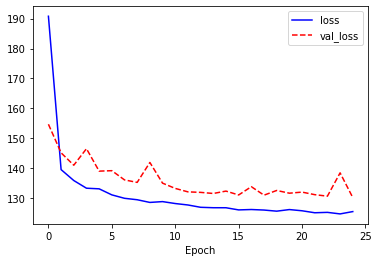

In [13]:
plt.plot(hist7.history['loss'], 'b-', label='loss')
plt.plot(hist7.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [14]:
model8.compile(loss='mse', optimizer='adam')
hist8 = model8.fit(X_train_2, Y_train_2, epochs=25, batch_size=48, validation_split=0.25)
model8.evaluate(X_valid_2, Y_valid_2)

Epoch 1/25
615/615 [==============================] - 1s 1ms/step - loss: 373.1551 - val_loss: 163.8447
Epoch 2/25
615/615 [==============================] - 1s 1ms/step - loss: 152.5000 - val_loss: 150.2012
Epoch 3/25
615/615 [==============================] - 1s 1ms/step - loss: 150.9749 - val_loss: 147.0889
Epoch 4/25
615/615 [==============================] - 1s 1ms/step - loss: 146.7108 - val_loss: 147.1102
Epoch 5/25
615/615 [==============================] - 1s 1ms/step - loss: 145.8405 - val_loss: 142.2581
Epoch 6/25
615/615 [==============================] - 1s 1ms/step - loss: 141.5623 - val_loss: 144.4173
Epoch 7/25
615/615 [==============================] - 1s 1ms/step - loss: 142.1645 - val_loss: 144.0595
Epoch 8/25
615/615 [==============================] - 1s 1ms/step - loss: 138.7153 - val_loss: 139.1425
Epoch 9/25
615/615 [==============================] - 1s 1ms/step - loss: 138.9164 - val_loss: 137.1708
Epoch 10/25
615/615 [==============================] - 1s 1ms/st

139.7083282470703

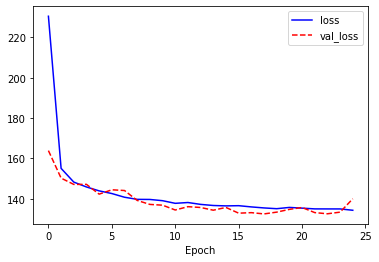

In [15]:
plt.plot(hist8.history['loss'], 'b-', label='loss')
plt.plot(hist8.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [16]:
results7 = pd.DataFrame()

for q in q_lst:
    model7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model7.fit(Day, Day7, epochs=25, batch_size=48, validation_split=0.25)
    pred = pd.DataFrame(model7.predict(df_test))
    results7 = pd.concat([results7, pred], axis=1)

results7.shape

Epoch 1/25
820/820 [==============================] - 1s 1ms/step - loss: 1.5074 - val_loss: 1.5778
Epoch 2/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3785 - val_loss: 1.5646
Epoch 3/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3606 - val_loss: 1.5571
Epoch 4/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3586 - val_loss: 1.5582
Epoch 5/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3684 - val_loss: 1.5683
Epoch 6/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3467 - val_loss: 1.5815
Epoch 7/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3517 - val_loss: 1.5922
Epoch 8/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3697 - val_loss: 1.5662
Epoch 9/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3611 - val_loss: 1.5847
Epoch 10/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3645 - val_loss: 1.5606

820/820 [==============================] - 2s 1ms/step - loss: 2.5438 - val_loss: 2.9697
Epoch 2/25
820/820 [==============================] - 1s 1ms/step - loss: 2.5146 - val_loss: 2.9560
Epoch 3/25
820/820 [==============================] - 1s 1ms/step - loss: 2.5177 - val_loss: 2.9722
Epoch 4/25
820/820 [==============================] - 1s 1ms/step - loss: 2.4997 - val_loss: 2.9556
Epoch 5/25
820/820 [==============================] - 1s 1ms/step - loss: 2.5345 - val_loss: 2.9877
Epoch 6/25
820/820 [==============================] - 1s 1ms/step - loss: 2.5316 - val_loss: 2.9757
Epoch 7/25
820/820 [==============================] - 1s 1ms/step - loss: 2.5332 - val_loss: 2.9640
Epoch 8/25
820/820 [==============================] - 1s 1ms/step - loss: 2.5786 - val_loss: 2.9759
Epoch 9/25
820/820 [==============================] - 1s 1ms/step - loss: 2.5257 - val_loss: 2.9539
Epoch 10/25
820/820 [==============================] - 1s 1ms/step - loss: 2.5725 - val_loss: 2.9390
Epoch 11/2

820/820 [==============================] - 1s 1ms/step - loss: 2.4787 - val_loss: 2.9428
Epoch 4/25
820/820 [==============================] - 1s 1ms/step - loss: 2.4582 - val_loss: 2.9590
Epoch 5/25
820/820 [==============================] - 1s 1ms/step - loss: 2.4852 - val_loss: 2.9603
Epoch 6/25
820/820 [==============================] - 1s 1ms/step - loss: 2.4938 - val_loss: 2.9558
Epoch 7/25
820/820 [==============================] - 1s 1ms/step - loss: 2.5165 - val_loss: 2.9251
Epoch 8/25
820/820 [==============================] - 1s 1ms/step - loss: 2.5461 - val_loss: 2.9099
Epoch 9/25
820/820 [==============================] - 1s 1ms/step - loss: 2.4771 - val_loss: 2.9780
Epoch 10/25
820/820 [==============================] - 1s 1ms/step - loss: 2.5402 - val_loss: 2.9230
Epoch 11/25
820/820 [==============================] - 1s 1ms/step - loss: 2.4283 - val_loss: 2.9332
Epoch 12/25
820/820 [==============================] - 1s 1ms/step - loss: 2.4488 - val_loss: 2.9339
Epoch 13

Epoch 9/25
820/820 [==============================] - 1s 1ms/step - loss: 1.8044 - val_loss: 2.1332
Epoch 10/25
820/820 [==============================] - 1s 1ms/step - loss: 1.8493 - val_loss: 2.1623
Epoch 11/25
820/820 [==============================] - 1s 1ms/step - loss: 1.7700 - val_loss: 2.1552
Epoch 12/25
820/820 [==============================] - 1s 1ms/step - loss: 1.7962 - val_loss: 2.1735
Epoch 13/25
820/820 [==============================] - 1s 1ms/step - loss: 1.8117 - val_loss: 2.2065
Epoch 14/25
820/820 [==============================] - 1s 1ms/step - loss: 1.8056 - val_loss: 2.1542
Epoch 15/25
820/820 [==============================] - 1s 1ms/step - loss: 1.7936 - val_loss: 2.1891
Epoch 16/25
820/820 [==============================] - 1s 1ms/step - loss: 1.7966 - val_loss: 2.1467
Epoch 17/25
820/820 [==============================] - 1s 1ms/step - loss: 1.8101 - val_loss: 2.1597
Epoch 18/25
820/820 [==============================] - 1s 1ms/step - loss: 1.8145 - val_loss

820/820 [==============================] - 1s 1ms/step - loss: 0.7261 - val_loss: 0.8731
Epoch 15/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7221 - val_loss: 0.8878
Epoch 16/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7271 - val_loss: 0.8890
Epoch 17/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7285 - val_loss: 0.8592
Epoch 18/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7268 - val_loss: 0.8806
Epoch 19/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7244 - val_loss: 0.8599
Epoch 20/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7335 - val_loss: 0.8614
Epoch 21/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7415 - val_loss: 0.8657
Epoch 22/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7247 - val_loss: 0.8710
Epoch 23/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7214 - val_loss: 0.8969
Ep

(3888, 9)

In [17]:
results8 = pd.DataFrame()

for q in q_lst:
    model8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model8.fit(Day, Day8, epochs=25, batch_size=48, validation_split=0.25)
    pred = pd.DataFrame(model8.predict(df_test))
    results8 = pd.concat([results8, pred], axis=1)

results8.shape

Epoch 1/25
820/820 [==============================] - 1s 1ms/step - loss: 1.4847 - val_loss: 1.5784
Epoch 2/25
820/820 [==============================] - 1s 1ms/step - loss: 1.4035 - val_loss: 1.5628
Epoch 3/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3896 - val_loss: 1.5739
Epoch 4/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3754 - val_loss: 1.5592
Epoch 5/25
820/820 [==============================] - 1s 2ms/step - loss: 1.3924 - val_loss: 1.5793
Epoch 6/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3846 - val_loss: 1.5709
Epoch 7/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3927 - val_loss: 1.5787
Epoch 8/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3956 - val_loss: 1.5770
Epoch 9/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3995 - val_loss: 1.5592
Epoch 10/25
820/820 [==============================] - 1s 1ms/step - loss: 1.3951 - val_loss: 1.5756

820/820 [==============================] - 1s 1ms/step - loss: 2.6883 - val_loss: 3.1311
Epoch 2/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6613 - val_loss: 3.1518
Epoch 3/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6682 - val_loss: 3.0761
Epoch 4/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6520 - val_loss: 3.0746
Epoch 5/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6774 - val_loss: 3.1423
Epoch 6/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6539 - val_loss: 3.0209
Epoch 7/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6793 - val_loss: 3.0849
Epoch 8/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6778 - val_loss: 3.0830
Epoch 9/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6774 - val_loss: 3.0860
Epoch 10/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6827 - val_loss: 3.0796
Epoch 11/2

820/820 [==============================] - 1s 1ms/step - loss: 2.6537 - val_loss: 3.1196
Epoch 3/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6608 - val_loss: 3.1246
Epoch 4/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6713 - val_loss: 3.1372
Epoch 5/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6727 - val_loss: 3.1395
Epoch 6/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6354 - val_loss: 3.0894
Epoch 7/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6764 - val_loss: 3.1132
Epoch 8/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6740 - val_loss: 3.1544
Epoch 9/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6436 - val_loss: 3.0992
Epoch 10/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6702 - val_loss: 3.1133
Epoch 11/25
820/820 [==============================] - 1s 1ms/step - loss: 2.6309 - val_loss: 3.0844
Epoch 12/

820/820 [==============================] - 1s 1ms/step - loss: 1.9189 - val_loss: 2.2800
Epoch 8/25
820/820 [==============================] - 1s 1ms/step - loss: 1.9165 - val_loss: 2.2688
Epoch 9/25
820/820 [==============================] - 1s 1ms/step - loss: 1.8928 - val_loss: 2.2556
Epoch 10/25
820/820 [==============================] - 1s 1ms/step - loss: 1.9169 - val_loss: 2.2799
Epoch 11/25
820/820 [==============================] - 1s 1ms/step - loss: 1.8829 - val_loss: 2.2679
Epoch 12/25
820/820 [==============================] - 1s 1ms/step - loss: 1.9050 - val_loss: 2.2961
Epoch 13/25
820/820 [==============================] - 1s 1ms/step - loss: 1.9053 - val_loss: 2.3117
Epoch 14/25
820/820 [==============================] - 1s 1ms/step - loss: 1.9019 - val_loss: 2.3091
Epoch 15/25
820/820 [==============================] - 1s 1ms/step - loss: 1.8907 - val_loss: 2.2653
Epoch 16/25
820/820 [==============================] - 1s 1ms/step - loss: 1.8860 - val_loss: 2.3141
Epoc

820/820 [==============================] - 1s 1ms/step - loss: 0.7551 - val_loss: 0.9716
Epoch 13/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7545 - val_loss: 0.9485
Epoch 14/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7592 - val_loss: 0.9311
Epoch 15/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7498 - val_loss: 0.9336
Epoch 16/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7460 - val_loss: 0.9614
Epoch 17/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7625 - val_loss: 0.9313
Epoch 18/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7453 - val_loss: 0.9726
Epoch 19/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7547 - val_loss: 0.9570
Epoch 20/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7492 - val_loss: 0.9193
Epoch 21/25
820/820 [==============================] - 1s 1ms/step - loss: 0.7588 - val_loss: 0.9250
Ep

(3888, 9)

In [49]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results7.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results8.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,-0.218432,-0.100355,0.101065,-0.015347,0.023308,0.012284,0.000281,0.097224,0.258666
1,0.csv_Day7_0h30m,-0.219941,-0.094147,0.102062,-0.013087,0.024684,0.017897,-0.002198,0.095518,0.254257
2,0.csv_Day7_1h00m,-0.210571,-0.089169,0.094854,-0.015206,0.012483,0.038093,0.011141,0.088657,0.250725
3,0.csv_Day7_1h30m,-0.209991,-0.093107,0.093455,-0.018111,0.011124,0.036909,0.012184,0.089943,0.250729
4,0.csv_Day7_2h00m,-0.199464,-0.096004,0.090247,-0.017586,-0.000893,0.032356,0.029866,0.085573,0.250789
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,-0.135986,-0.051198,-0.068829,-0.111960,-0.075746,-0.056690,0.006875,-0.038222,0.080066
7772,80.csv_Day8_22h00m,-0.147341,-0.054908,-0.075984,-0.131064,-0.082269,-0.064004,0.010350,-0.033585,0.089289
7773,80.csv_Day8_22h30m,-0.145475,-0.057054,-0.080355,-0.134822,-0.083201,-0.064808,0.009470,-0.034172,0.086425
7774,80.csv_Day8_23h00m,-0.166278,-0.068832,-0.092727,-0.152519,-0.088396,-0.071750,0.013204,-0.033105,0.092407


In [28]:
test = pd.concat([df_test, df_test])
test.shape

(7776, 7)

In [37]:
test[['TARGET']].reset_index()[['TARGET']]

,TARGET
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
7771,0.0
7772,0.0
7773,0.0
7774,0.0


In [50]:
submission.shape, test.shape

((7776, 10), (7776, 7))

In [62]:
submission.to_csv('./submission/submission_20210115-2.csv', index=False)

In [51]:
submission = pd.concat([submission, test[['TARGET']].reset_index()[['TARGET']]], axis=1)
submission.shape

(7776, 11)

In [57]:
submission.loc[submission.TARGET == 0, ['q_0.1', 'q_0.2', 'q_0.3', 'q_0.4', 'q_0.5', 'q_0.6', 'q_0.7','q_0.8', 'q_0.9']] = 0

In [61]:
submission.drop('TARGET', axis=1, inplace=True)